
# IS-4100: PCA and Clustering with NFL Data

**Objective:**

This lab will introduce you to principal component analysis (PCA) and clustering techniques to analyze and interpret NFL data. You will explore how dimensionality reduction can simplify data and how clustering can reveal patterns within NFL team or player performance metrics.

---

## Section 1: Data Preparation and Exploration

### Load the Data
- Use either `nflfastR` or `nfl_data_py` to load the play-by-play data or season stats for a specific range.
- Filter the data to focus on key columns such as `yards_gained`, `pass_attempt`, `rush_attempt`, `touchdown`, `interception`, `sack`, etc.

### Feature Engineering
- Create aggregated metrics for each team or player, such as:
  - Average yards per game
  - Touchdowns per game
  - Passing and rushing attempts per game
  - Average turnovers per game
- Ensure the final dataset has all numeric columns necessary for PCA and clustering.

### Data Cleaning
- Check for missing values, handling them appropriately.
- Standardize or normalize data to ensure comparability across features.

---

## Section 2: Principal Component Analysis (PCA)

### Perform PCA
- Apply PCA to the dataset to reduce it to two or three principal components.
- Use a scree plot to determine the number of components that capture the majority of variance.

### Interpret PCA Results
- Examine the component loadings to understand which metrics contribute most to each principal component.
- Discuss how PCA has simplified the data and retained the most critical information.

### Visualization
- Plot the data points in a 2D or 3D scatterplot using the principal components as axes.
- Label data points by team or player for better insights.

---

## Section 3: Clustering

### Choosing a Clustering Algorithm
- Select either K-means or hierarchical clustering for this analysis.
- Determine an appropriate number of clusters by using techniques like the elbow method or silhouette score.

### Run Clustering Algorithm
- Apply the chosen clustering algorithm to the PCA-reduced dataset.
- Assign a cluster label to each team or player based on the results.

### Visualize Clusters
- Create a scatter plot showing the clusters with different colors, and label key data points.
- Discuss the composition of each cluster (e.g., are certain teams or players consistently high-performing in specific metrics?).

---

## Section 4: Interpretation and Analysis

### Analyze Cluster Characteristics
- Compare clusters to identify patterns, such as clusters of teams with strong passing vs. rushing stats or players with high-risk, high-reward play styles.

### Discuss Findings
- Write a summary explaining how PCA helped to reduce data complexity and what the clusters reveal about NFL team or player performance.


---

## Questions for Reflection:
1. How did PCA simplify the dataset, and what insights were preserved?
2. Were there any clusters that grouped similar types of players or teams? Describe these patterns.
3. If you were to adjust the clustering parameters, what changes might you explore?

In [ ]:
# Load Packages
!pip install nfl_data_py
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.cluster.vq import vq, kmeans

In [ ]:
## I want to look at specifically the 2023 season
pbp = nfl.import_pbp_data([2023])

2023 done.
Downcasting floats.


In [ ]:
# filtering for columns that could be relevant for my research
offense_columns = [
    'game_id',
    'posteam',
    'defteam',
    'yards_gained',
    'pass_attempt',
    'rush_attempt',
    'touchdown',
    'interception',
    'sack'
]

# apply the filter to my play by play df
filtered_pbp = pbp[offense_columns]

# Drop rows with missing values to ensure there are no NaN's
filtered_pbp = filtered_pbp.dropna()

In [ ]:
# Aggregate the data by team and by game
gbg_data = filtered_pbp.groupby(['posteam', 'game_id']).agg(
    total_yards=('yards_gained', 'sum'),
    td_scored=('touchdown', 'sum'),
    total_pass_attempts=('pass_attempt', 'sum'),
    total_rush_attempts=('rush_attempt', 'sum'),
    total_int=('interception', 'sum'),
    total_sacks=('sack', 'sum')
)

gbg_data = gbg_data.reset_index()

<Axes: xlabel='total_pass_attempts', ylabel='total_rush_attempts'>

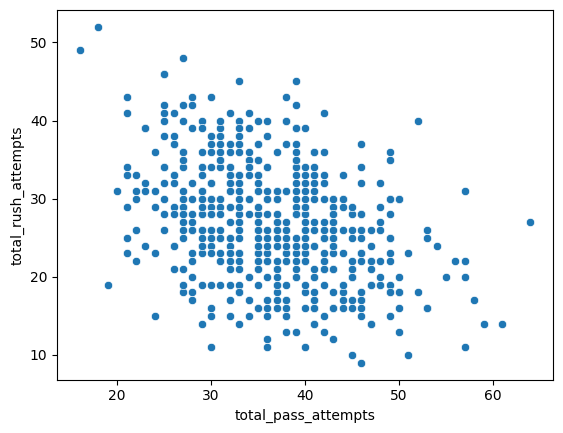

In [ ]:
sns.scatterplot(data=gbg_data, x='total_pass_attempts', y='total_rush_attempts')

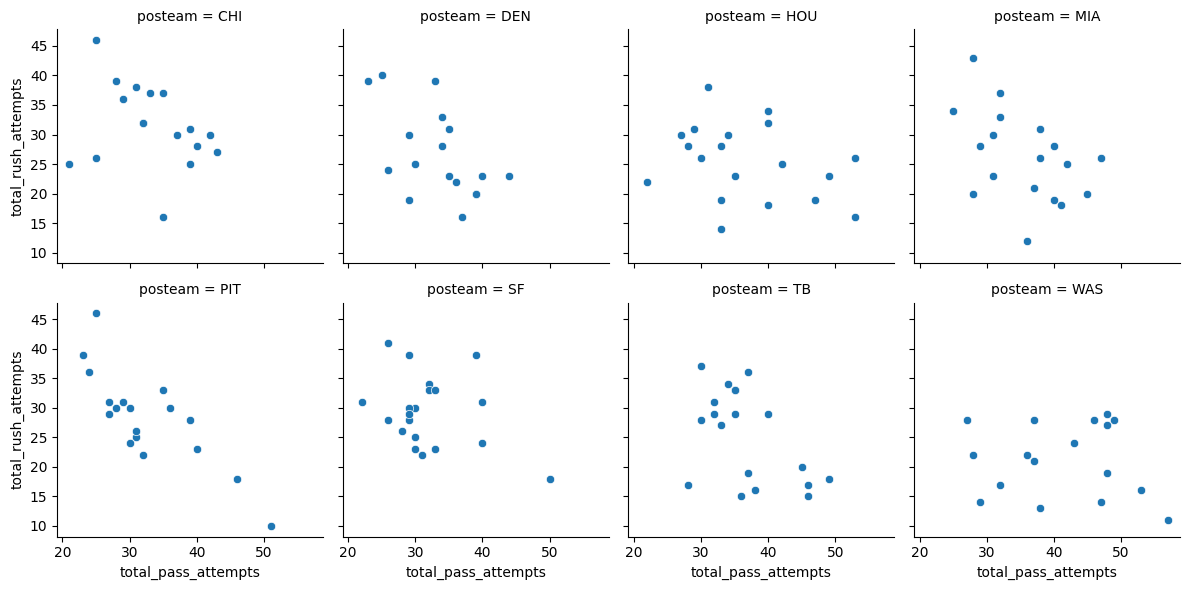

In [ ]:
# Filter for only my teams
my_teams = ['MIA', 'PIT', 'HOU', 'DEN', 'WAS', 'CHI', 'TB', 'SF']
filtered_teams_data = gbg_data[gbg_data['posteam'].isin(my_teams)]

# create a facetgrid
g = sns.FacetGrid(filtered_teams_data, col='posteam', col_wrap=4)
g.map(sns.scatterplot, 'total_pass_attempts', 'total_rush_attempts')

In [ ]:
# use KNNImputer to impute missing values

# create a list of columns to impute
cols_impute = ['total_yards', 'td_scored', 'total_pass_attempts', 'total_rush_attempts',
               'total_int', 'total_sacks']

# create a KNN combine object
# axis = 1 refers to the column axis
gbg_knn_py = gbg_data.drop(cols_impute, axis = 1)

# create an instance of the KNN imputer class
imputer = KNNImputer(n_neighbors = 9)

# now, fit_transform this object on our data
# most models have 3 modes: fit, transform, fit_transform
# fit - train a model on the data passed to it
# transform - transform the data but it must be fit first
# fit_transform - fit on the data, then transform it
knn_out_py = imputer.fit_transform(gbg_data[cols_impute])

# convert back to a df
knn_out_py = pd.DataFrame(knn_out_py)

# change column names from imputer to match og object
knn_out_py.columns = cols_impute

#combine this data back with original
# axes typically 0 or 1
# o refers to the rows; 1 to the columns
gbg_knn_py = pd.concat(
    [gbg_knn_py, knn_out_py], axis = 1
)

In [ ]:
# loop through and check for missing values
for i in range(len(cols_impute)):
  print(gbg_knn_py[cols_impute[i]].isna().sum())

0
0
0
0
0
0


##**PCA**: Team Pass Attempts and Rush Attempts

In [ ]:
pca_pass_rush = PCA(svd_solver = 'full')

# fix the pass attempt and rush attempt data
pass_rush_py = gbg_data[['total_pass_attempts', 'total_rush_attempts']].query(
    'total_pass_attempts.notnull() & total_rush_attempts.notnull()'
).copy()

# fit the PCA model to the data
# then project the data to the new PCs
pca_fit_pass_rush_py = pca_pass_rush.fit_transform(pass_rush_py)

In [ ]:
# explained variance ratio
pca_pass_rush.explained_variance_ratio_

array([0.69509125, 0.30490875], dtype=float32)

- The 1st Component explains nearly 70% of the variance, the 2nd component explains the other 30%

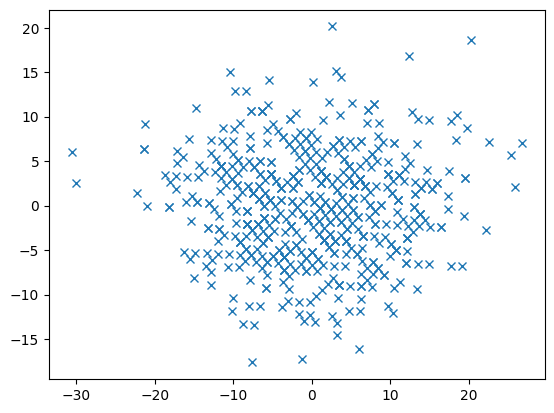

In [ ]:
# plot our PC1 and PC2
plt.plot(
    pca_fit_pass_rush_py[:,0],
    pca_fit_pass_rush_py[:,1],
    'x'
)

plt.show();

In [ ]:
# pull out the components
pca_pass_rush.components_

array([[ 0.73813736, -0.6746505 ],
       [ 0.6746505 ,  0.73813736]], dtype=float32)

In [ ]:
# KNN is sensitive to scale
# subtract mean & divide by std for select cols
scaled_gbg_knn_py = (
    gbg_knn_py[cols_impute] - gbg_knn_py[cols_impute].mean()
) / gbg_knn_py[cols_impute].std()

In [ ]:
scaled_gbg_knn_py.head() # standard deviations above/below the mean

,total_yards,td_scored,total_pass_attempts,total_rush_attempts,total_int,total_sacks
0,-1.444418,-1.670161,-0.448147,-0.252729,-0.863721,0.241585
1,0.555914,0.403895,-0.705262,0.412962,-0.863721,-1.404272
2,0.778174,0.403895,-1.605165,0.546101,-0.863721,-0.307034
3,0.333655,-0.287457,0.708871,-0.119591,-0.863721,-0.855653
4,-0.461798,1.095247,-0.191032,-0.652144,1.358947,0.241585


##**PCA**: All General Offensive Data

In [ ]:
pca = PCA(svd_solver = 'full')

# fit pca on scaled data and transform it
pca_fit_py = pca.fit_transform(scaled_gbg_knn_py)

# showcase rotation (PCs) of data
rotation = pd.DataFrame(pca.components_, index = cols_impute)
print(rotation)

                            0         1         2         3         4  \
total_yards          0.495085  0.484170 -0.226390  0.471326 -0.255188   
td_scored            0.472763  0.305835  0.679326 -0.250559  0.397842   
total_pass_attempts -0.103137 -0.031275 -0.376666 -0.036797  0.790697   
total_rush_attempts  0.031258  0.199781 -0.159596  0.533795  0.381520   
total_int           -0.195782  0.703572 -0.345699 -0.552750 -0.075770   
total_sacks          0.693860 -0.368974 -0.447668 -0.351066 -0.010024   

                            5  
total_yards         -0.426555  
td_scored            0.020445  
total_pass_attempts -0.468990  
total_rush_attempts  0.709327  
total_int            0.189406  
total_sacks          0.242203  


In [ ]:
# print our explained variance
pca.explained_variance_

array([2.2823818 , 1.3793339 , 0.8372936 , 0.73050785, 0.56030995,
       0.21016647], dtype=float32)

In [ ]:
# convert to %
pca_percent_py = pca.explained_variance_ratio_.round(4) * 100
print(pca_percent_py)

[38.04     22.99     13.950001 12.179999  9.34      3.5     ]


38.04 + 22.99 + 13.95001 + 12.179999 = 87.16
- Use first 4 PC's


In [ ]:
# create a df for PCA
pca_fit_py = pd.DataFrame(pca_fit_py)

# add column names
pca_fit_py.columns = ["PC" + str(i + 1) for i in range(len(pca_fit_py.columns))]

gbg_knn_py = pd.concat([gbg_knn_py, pca_fit_py], axis = 1)

gbg_knn_py.head()

,posteam,game_id,total_yards,td_scored,total_pass_attempts,total_rush_attempts,total_int,total_sacks,PC1,PC2,PC3,PC4,PC5,PC6
0,ARI,2023_01_ARI_WAS,210.0,0.0,33.0,25.0,0.0,3.0,-1.424053,-1.773461,-0.416934,-0.600364,-0.486465,-0.029461
1,ARI,2023_02_NYG_ARI,381.0,3.0,31.0,30.0,0.0,0.0,1.644493,-0.568570,0.156134,-0.894554,-0.009660,0.075987
2,ARI,2023_03_DAL_ARI,400.0,3.0,24.0,31.0,0.0,2.0,1.552982,-1.085749,-0.047320,0.105384,0.392152,0.852073
3,ARI,2023_04_ARI_SF,362.0,2.0,42.0,26.0,0.0,1.0,0.394557,0.220225,-0.569679,-1.160433,-0.543145,-0.136365
4,ARI,2023_05_CIN_ARI,294.0,4.0,35.0,22.0,2.0,3.0,-0.412305,0.695857,1.070542,0.576580,1.230299,-0.365185


<Axes: xlabel='PC1', ylabel='PC2'>

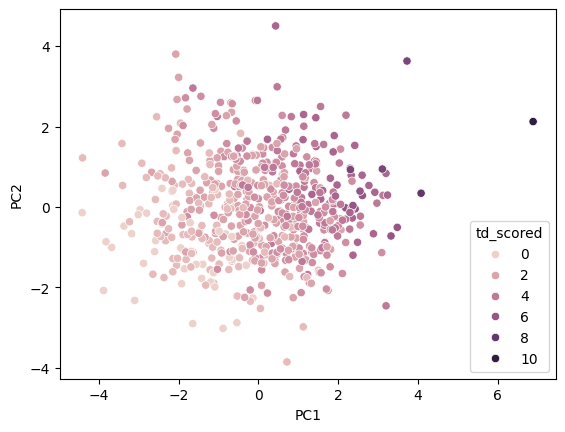

In [ ]:
# Scatterplot of PC1 and PC2 with TD's Scored as the hue
sns.scatterplot(data = gbg_knn_py, x = 'PC1', y = 'PC2', hue = 'td_scored')

In [ ]:
# to keep roughly 90% variance, keep the first 4 PC's
pca = PCA(svd_solver='full', n_components=4)

pca_fit_py = pca.fit_transform(scaled_gbg_knn_py)

In [ ]:
pca.explained_variance_ratio_

array([0.38039738, 0.22988923, 0.13954909, 0.12175144], dtype=float32)

##**Clustering**

In [ ]:
# clustering
k_means_fit_py = kmeans(
    gbg_knn_py[["PC1", "PC2"]], 6, seed = 1234
)

# add cluster label to data
gbg_knn_py['cluster'] = (
    vq(gbg_knn_py[['PC1', 'PC2']], k_means_fit_py[0])[0]
    )

In [ ]:
# cluster labels
gbg_knn_py['cluster'].unique()

array([3, 2, 5, 1, 4, 0], dtype=int32)

In [ ]:
# group by cluster and print some data
print(
    gbg_knn_py.query('cluster == 1')
    .groupby('posteam')
    .agg({'total_pass_attempts': ['count', 'mean'], 'total_rush_attempts':['count', 'mean']})
)

        total_pass_attempts            total_rush_attempts           
                      count       mean               count       mean
posteam                                                              
ARI                       7  38.428570                   7  26.142857
ATL                       4  37.250000                   4  25.250000
BAL                       2  34.000000                   2  24.500000
BUF                       3  42.666668                   3  22.666666
CAR                       3  41.666668                   3  26.666666
CHI                       3  37.666668                   3  29.000000
CIN                       1  42.000000                   1  15.000000
CLE                       6  39.833332                   6  32.833332
DAL                       6  40.500000                   6  26.166666
DEN                       5  37.400002                   5  23.799999
DET                       3  41.333332                   3  22.666666
GB                  

In [ ]:
# group by cluster & team
gbg_knn_py_cluster = (
    gbg_knn_py.groupby(['cluster', 'posteam']).agg(
        {'total_pass_attempts': ['count', 'mean'], 'total_rush_attempts':['count', 'mean']}
    )
    )

# fix column names
gbg_knn_py_cluster.columns = list(
    map(
        "_".join, gbg_knn_py_cluster.columns
    )
)

# reset index
gbg_knn_py_cluster.reset_index(inplace = True)

# rename columns
gbg_knn_py_cluster.rename(
    columns = {
        'total_pass_attempts_count' : 'n',
        'total_pass_attempts_mean' : 'Pass Attempts',
        'total_rush_attempts_mean' : 'Rush Attempts',
    }, inplace = True
)

# type cast cluster col
gbg_knn_py_cluster.cluster = gbg_knn_py_cluster.cluster.astype(str)

# view obj
gbg_knn_py_cluster.tail()

,cluster,posteam,n,Pass Attempts,total_rush_attempts_count,Rush Attempts
169,5,SEA,4,29.500000,4,26.000000
170,5,SF,5,31.200001,5,30.400000
171,5,TB,6,32.666668,6,32.333332
172,5,TEN,5,27.000000,5,27.200001
173,5,WAS,1,27.000000,1,28.000000


In [ ]:
# view dims
gbg_knn_py_cluster.shape

(174, 6)

In [ ]:
# group by cluster and not position
gbg_knn_py_cluster.groupby('cluster').agg(
    {
        'Pass Attempts': ['mean'],
        'Rush Attempts': ['mean']
    }
)

,Pass Attempts,Rush Attempts
,mean,mean
cluster,,
0,43.250000,27.893679
1,39.997063,23.776058
2,31.797588,34.190933
3,35.228817,21.550123
4,46.913692,18.589285
5,29.895611,31.175484


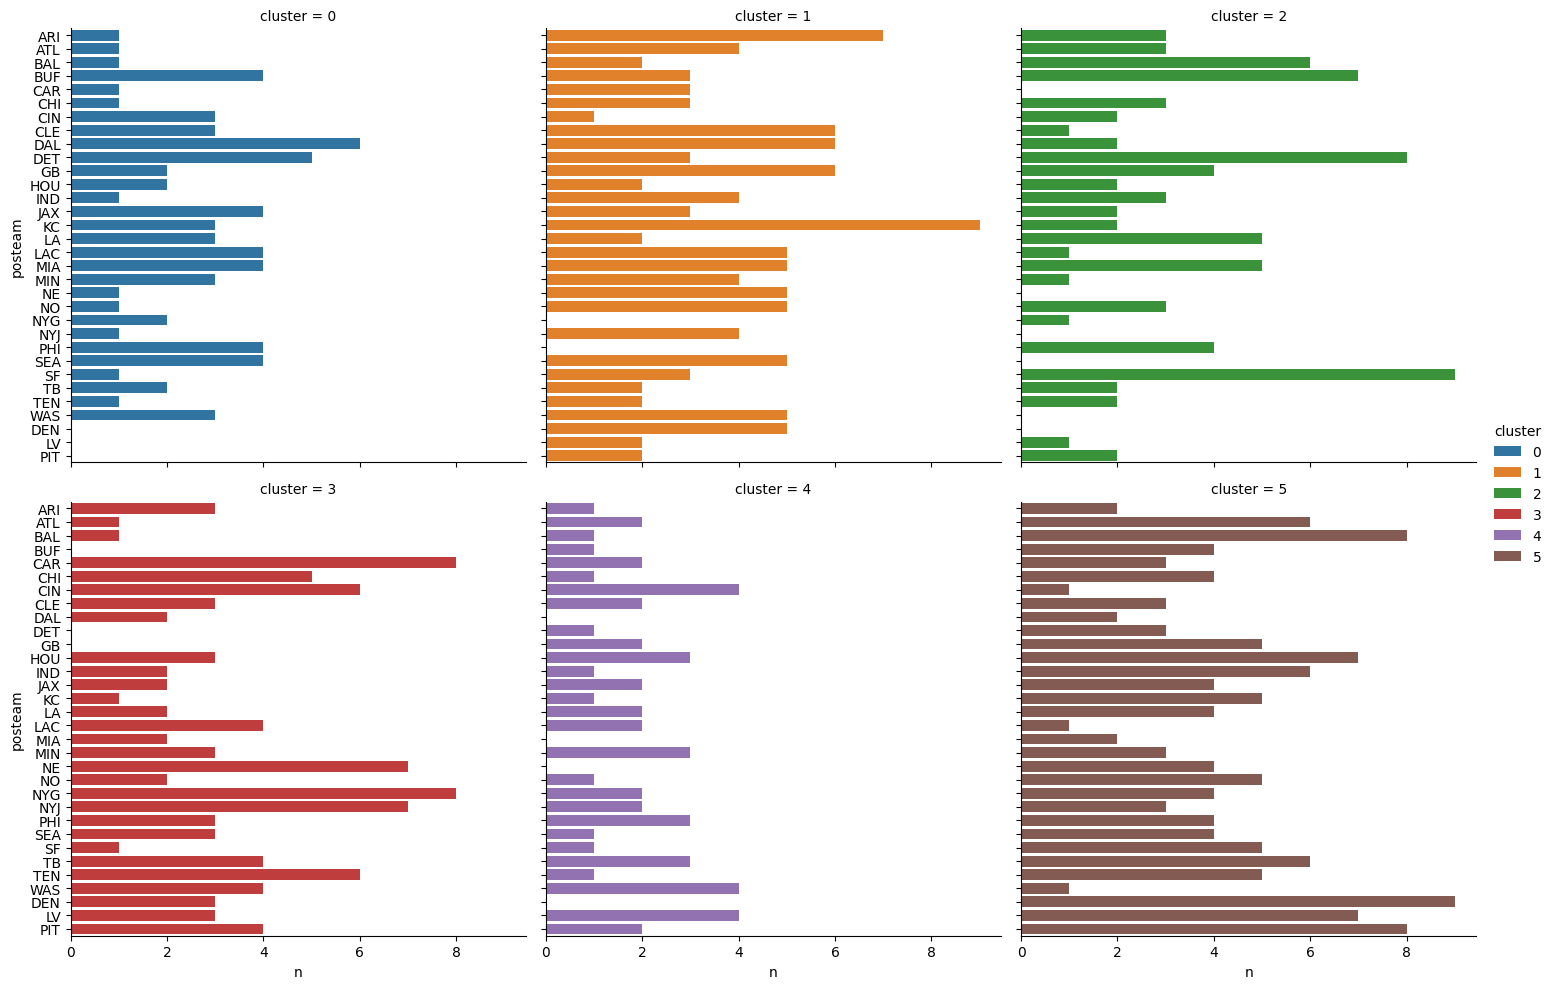

In [ ]:
# catplot
sns.catplot(
    gbg_knn_py_cluster,
    x = 'n', # number of instances
    y = 'posteam', # position played
    col = 'cluster', # col by cluster
    hue = 'cluster', # color by cluster
    col_wrap = 3, # facet wrap - 3 cols
    kind = 'bar' # horizontal chart
)

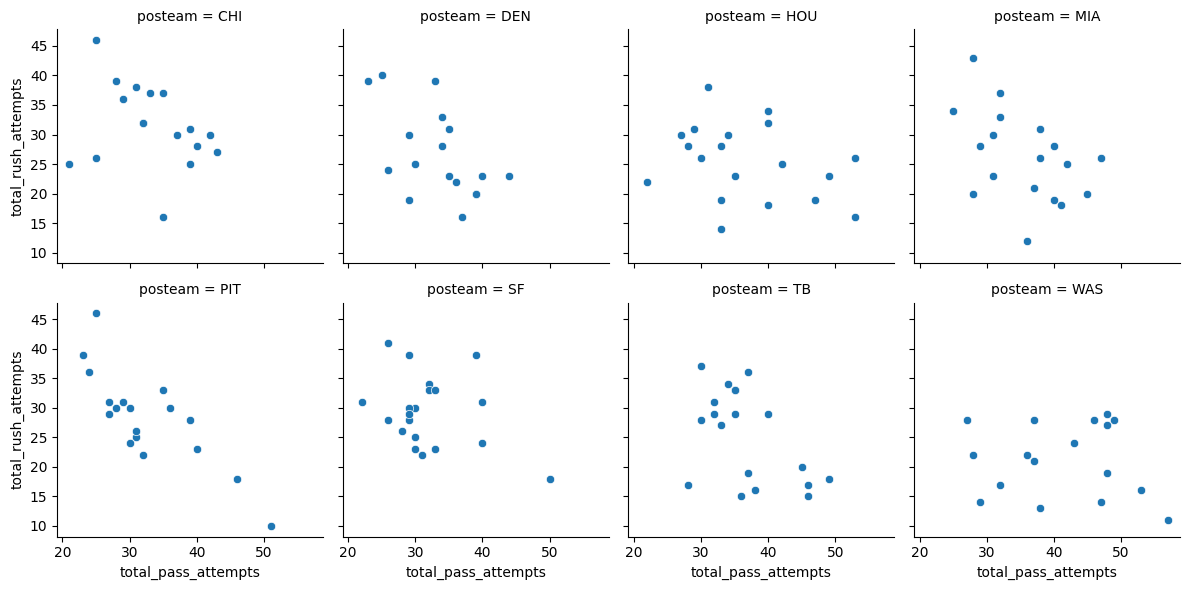

In [ ]:
# create a facetgrid
g = sns.FacetGrid(filtered_teams_data, col='posteam', col_wrap=4)
g.map(sns.scatterplot, 'total_pass_attempts', 'total_rush_attempts')

##**Analysis**

**Cluster 0**: Pass-heavy offense, above-average total plays

**Cluster 1**: Pass-heavy offense, average total plays

**Cluster 2**: Balanced offense, above-average total plays

**Cluster 3**: Pass-heavy offense, below-average total plays

**Cluster 4**: Extremely pass-heavy offense, average total plays

**Cluster 5**: Balanced offense, average total plays


- A true "run-dominant" offense no longer really exists in the modern NFL - even the most run-heavy teams still rely on a nearly balanced dose of passing

- A high number of instances fall under cluster 5, which is a balanced offensive in pass attempts vs. rush attempts

**My Teams in 2023**:
- *Washington* was the most pass-heavy by a wide margin
- *Houston* & *Tampa Bay* were slightly pass-heavy
- *San Francisco*, *Miami*, *Pittsburgh*, & *Denver* were extremely balanced on a low # of total plays
- *Chicago* was rush-heavy

